In [ ]:
import pickle
from glob import glob
import random
from tqdm import tqdm
MODEL_DIR = "/common/home/dm1487/robotics_research/ktamp/ml4kp_ktamp/resources/models"
DATA_DIR = "/common/users/dm1487/namo_data/idfs_test_set/goal_proximity"
xml_files = []
success = 0
total = 0
solution_depths = []
nodes_expanded = []
terminal_checks = []
all_datafiles = list(glob(f"{DATA_DIR}/*/*.pkl"))

failed_data = []
# random.shuffle(all_datafiles)
for file in tqdm(all_datafiles):
    if "env" in file:
        with open(file, "rb") as f:
            data = pickle.load(f)
            if "episode_results" not in data:
                continue
            for episode_result in data['episode_results']:
                total += 1
                if episode_result['action_sequence'] is not None:
                    if episode_result['solution_found']:
                        success += 1
                    else:
                        failed_data.append(data)
                    solution_depths.append(episode_result['solution_depth'])
                    nodes_expanded.append(episode_result['nodes_expanded'])
                    terminal_checks.append((episode_result['xml_file'].split('/')[-1], episode_result['terminal_checks']))
                    
                else:
                    if not episode_result['solution_found']:
                        failed_data.append(data)
                        # print(episode_result['terminal_checks'])
                        continue
                    if episode_result['solution_depth'] == 0:
                        total -= 1
                
print(f"Success rate: {success / total}", success, total)

100%|██████████| 702/702 [00:00<00:00, 1349.61it/s]

Success rate: 0.9157940663176265 10495 11460


In [5]:
import pickle
from glob import glob
from tqdm import tqdm
import statistics
import os

all_datafiles = []
level = "medium" # "easy" or "medium"
# heuristic = "goal_ml_mse_dice" # "no_heuristic" or "goal_proximity" or "single_stream" or "ml_both" or "goal_ml" 
# DATA_DIR = f"/common/users/dm1487/namo_data/idfs_test_set/{level}/{heuristic}"
# all_datafiles = list(glob(f"{DATA_DIR}/*/*.pkl"))
# # level = "easy" # "easy" or "medium"
# heuristic = "goal_ml_seq" # "no_heuristic" or "goal_proximity" or "single_stream" or "ml_both" or "goal_ml" 
# DATA_DIR = f"/common/users/dm1487/namo_data/idfs_test_set/{level}/{heuristic}"
# all_datafiles += list(glob(f"{DATA_DIR}/*/*.pkl"))

heuristic = "goal_proximity_eps_10" # "no_heuristic" or "goal_proximity" or "single_stream" or "ml_both" or "goal_ml" or "goal_ml_mse_dice_eps"
# heuristic = "goal_ml_mse_dice_eps_10_correct" # "no_heuristic" or "goal_proximity" or "single_stream" or "ml_both" or "goal_ml" or "goal_ml_mse_dice_eps"
DATA_DIR = f"/common/users/dm1487/namo_data/idfs_test_set/{level}/{heuristic}"
all_datafiles += list(glob(f"{DATA_DIR}/*/*.pkl"))
# DATA_DIR = "../test_ml"
# Focus only on episodes requiring manipulation
manipulation_episodes = 0
successful_manipulations = 0
timeout_episodes = 0
crashed_episodes = 0

solution_depths = []
nodes_expanded = []
terminal_checks = []
search_times = []

# Track trivial solution environments
trivial_solution_environments = []

# Track environment performance
environment_performance = {}

# Track processed XML files to avoid duplicates
processed_xml_files = set()

# all_datafiles = list(glob(f"{DATA_DIR}/*/*.pkl")) + list(glob(f"{DATA_DIR}/*/*.pkl"))
print(len(all_datafiles))
count_all_dp = 0
for file in tqdm(all_datafiles):
    if "env" in file:
        with open(file, "rb") as f:
            data = pickle.load(f)
            if "episode_results" not in data:
                continue
            sequence_lengths = []
            
            for ep_idx, episode_result in enumerate(data['episode_results']):
                episode_success = episode_result.get('success', True)
                solution_found = episode_result.get('solution_found', False)
                action_sequence = episode_result.get('action_sequence')
                state_observations = episode_result.get('state_observations')
                
                solution_depth = episode_result.get('solution_depth', 0)
                xml_file = episode_result.get('xml_file', 'unknown')
                
                # Extract filename with 2 parent folders
                if xml_file != 'unknown' and '/' in xml_file:
                    path_parts = xml_file.split('/')
                    if len(path_parts) >= 3:
                        xml_filename = '/'.join(path_parts[-3:])  # Take last 3 parts (2 parent folders + filename)
                    else:
                        xml_filename = xml_file
                else:
                    xml_filename = xml_file
                
                # Skip if we've already processed this XML file
                
                if xml_filename in processed_xml_files and ep_idx == 0:
                    print("skipping", xml_filename)
                    continue
                # Mark this XML file as processed
                processed_xml_files.add(xml_filename)
                
                # Initialize environment tracking
                if xml_filename not in environment_performance:
                    environment_performance[xml_filename] = {
                        'total_episodes': 0,
                        'successful_episodes': 0,
                        'timeout_episodes': 0,
                        'crashed_episodes': 0,
                        'trivial_episodes': 0,
                        'search_times': [],
                        'nodes_expanded': [],
                        'terminal_checks': []
                    }
                
                env_stats = environment_performance[xml_filename]
                
                # Check for trivial solutions and record them
                if solution_found and (solution_depth == 0 or not action_sequence):
                    trivial_solution_environments.append({
                        'xml_file': xml_file,
                        'solution_depth': solution_depth,
                        'action_sequence': action_sequence,
                        'episode_id': episode_result.get('episode_id', 'unknown')
                    })
                    env_stats['trivial_episodes'] += 1
                    continue
                
                # Skip episodes that didn't complete successfully
                if not episode_success:
                    crashed_episodes += 1
                    env_stats['crashed_episodes'] += 1
                    continue
                
                # Count this as a manipulation episode
                manipulation_episodes += 1
                env_stats['total_episodes'] += 1
                
                if solution_found and action_sequence:
                    # Successfully found solution requiring manipulation
                    successful_manipulations += 1
                    env_stats['successful_episodes'] += 1
                    
                    # Collect detailed statistics
                    solution_depths.append(episode_result['solution_depth'])
                    nodes_expanded.append(episode_result['nodes_expanded'])
                    terminal_checks.append(episode_result['terminal_checks'])
                    search_times.append(episode_result.get('search_time_ms', 0))
                    sequence_lengths.append(len(action_sequence))
                    
                    # Collect environment-specific stats
                    env_stats['search_times'].append(episode_result.get('search_time_ms', 0))
                    env_stats['nodes_expanded'].append(episode_result['nodes_expanded'])
                    env_stats['terminal_checks'].append(episode_result['terminal_checks'])
                    
                else:
                    # No solution found (timeout/limits)
                    timeout_episodes += 1
                    env_stats['timeout_episodes'] += 1
                    
                    # Still collect search effort stats
                    nodes_expanded.append(episode_result['nodes_expanded'])
                    terminal_checks.append(episode_result['terminal_checks'])
                    search_times.append(episode_result.get('search_time_ms', 0))
                    
                    # Collect environment-specific stats
                    env_stats['search_times'].append(episode_result.get('search_time_ms', 0))
                    env_stats['nodes_expanded'].append(episode_result['nodes_expanded'])
                    env_stats['terminal_checks'].append(episode_result['terminal_checks'])
                    
            if len(sequence_lengths) > 0:
                min_seq_length = min(sequence_lengths)
                for seq_length in sequence_lengths:
                    if seq_length == min_seq_length:
                        count_all_dp += 1
print(count_all_dp)
# Get unique trivial solution environments
unique_trivial_environments = {}
for env in trivial_solution_environments:
    # Extract filename with 2 parent folders for trivial environments too
    xml_file = env['xml_file']
    if xml_file != 'unknown' and '/' in xml_file:
        path_parts = xml_file.split('/')
        if len(path_parts) >= 3:
            xml_filename = '/'.join(path_parts[-3:])  # Take last 3 parts (2 parent folders + filename)
        else:
            xml_filename = xml_file
    else:
        xml_filename = xml_file
    
    if xml_filename not in unique_trivial_environments:
        unique_trivial_environments[xml_filename] = {
            'count': 0,
            'solution_depths': [],
            'has_actions': []
        }
    unique_trivial_environments[xml_filename]['count'] += 1
    unique_trivial_environments[xml_filename]['solution_depths'].append(env['solution_depth'])
    unique_trivial_environments[xml_filename]['has_actions'].append(env['action_sequence'] is not None)

# Print unique trivial solution environments
# print(f"=== UNIQUE TRIVIAL SOLUTION ENVIRONMENTS ===")
# print(f"Found {len(unique_trivial_environments)} unique environments with trivial solutions:")
# for xml_filename in sorted(unique_trivial_environments.keys()):
#     env_data = unique_trivial_environments[xml_filename]
#     depths = set(env_data['solution_depths'])
#     has_actions = set(env_data['has_actions'])
#     print(f"  {xml_filename} - count: {env_data['count']}, depths: {sorted(depths)}, has_actions: {sorted(has_actions)}")

# Calculate success rate for meaningful episodes only
success_rate = successful_manipulations / manipulation_episodes if manipulation_episodes > 0 else 0
timeout_rate = timeout_episodes / manipulation_episodes if manipulation_episodes > 0 else 0

print(f"\n=== MANIPULATION-ONLY EPISODE ANALYSIS ===")
print(f"(Ignoring zero-step solutions)")
print(f"")
print(f"Total manipulation episodes: {manipulation_episodes}")
print(f"├── Successful: {successful_manipulations}")
print(f"└── Timed out: {timeout_episodes}")
print(f"")
print(f"Success rate: {success_rate:.3f} ({successful_manipulations}/{manipulation_episodes})")
print(f"Timeout rate: {timeout_rate:.3f} ({timeout_episodes}/{manipulation_episodes})")

if solution_depths:
    print(f"\n=== SUCCESSFUL EPISODE STATISTICS ===")
    print(f"Solution depth:")
    print(f"  Average: {statistics.mean(solution_depths):.2f}")
    print(f"  Median: {statistics.median(solution_depths):.2f}")
    print(f"  Range: {min(solution_depths)} - {max(solution_depths)}")
    
    # Solution depth distribution
    depth_counts = {}
    for depth in solution_depths:
        depth_counts[depth] = depth_counts.get(depth, 0) + 1
    print(f"  Distribution:")
    for depth in sorted(depth_counts.keys()):
        percentage = depth_counts[depth] / len(solution_depths) * 100
        print(f"    {depth} steps: {depth_counts[depth]} episodes ({percentage:.1f}%)")

if nodes_expanded:
    print(f"\nSearch effort (all manipulation episodes):")
    print(f"  Nodes expanded - Average: {statistics.mean(nodes_expanded):.0f}")
    print(f"  Nodes expanded - Median: {statistics.median(nodes_expanded):.0f}")
    print(f"  Nodes expanded - Max: {max(nodes_expanded)}")
    
if terminal_checks:
    print(f"  Terminal checks - Average: {statistics.mean(terminal_checks):.0f}")
    print(f"  Terminal checks - Median: {statistics.median(terminal_checks):.0f}")
    print(f"  Terminal checks - Max: {max(terminal_checks)}")

if search_times:
    # Convert to seconds
    search_times_sec = [t/1000 for t in search_times if t > 0]
    if search_times_sec:
        print(f"  Search time - Average: {statistics.mean(search_times_sec):.2f}s")
        print(f"  Search time - Median: {statistics.median(search_times_sec):.2f}s")
        print(f"  Search time - Max: {max(search_times_sec):.2f}s")

print(f"\nEpisodes analyzed: {len(solution_depths)} successful + {timeout_episodes} timeouts = {manipulation_episodes} total")
print(f"Crashed episodes (excluded): {crashed_episodes}")
print(f"Trivial solution episodes (excluded): {len(trivial_solution_environments)}")

# Find environments with less than 50% success rate
low_success_environments = []
for xml_filename, stats in environment_performance.items():
    if stats['total_episodes'] > 0:
        success_rate = stats['successful_episodes'] / stats['total_episodes']
        if success_rate <= 0.5:
            low_success_environments.append({
                'xml_filename': xml_filename,
                'success_rate': success_rate,
                'total_episodes': stats['total_episodes'],
                'successful_episodes': stats['successful_episodes'],
                'timeout_episodes': stats['timeout_episodes']
            })

print(f"\n=== ENVIRONMENTS WITH ≤50% SUCCESS RATE ===")
print(f"Found {len(low_success_environments)} environments with ≤50% success rate")

# Find top 10 worst performing environments
print(f"\n=== TOP 10 WORST PERFORMING ENVIRONMENTS ===")
worst_environments = []
for xml_filename, stats in environment_performance.items():
    if stats['total_episodes'] > 0:
        success_rate = stats['successful_episodes'] / stats['total_episodes']
        avg_search_time = statistics.mean(stats['search_times']) if stats['search_times'] else 0
        avg_nodes_expanded = statistics.mean(stats['nodes_expanded']) if stats['nodes_expanded'] else 0
        avg_terminal_checks = statistics.mean(stats['terminal_checks']) if stats['terminal_checks'] else 0
        
        worst_environments.append({
            'xml_filename': xml_filename,
            'success_rate': success_rate,
            'total_episodes': stats['total_episodes'],
            'successful_episodes': stats['successful_episodes'],
            'timeout_episodes': stats['timeout_episodes'],
            'avg_search_time_ms': avg_search_time,
            'avg_nodes_expanded': avg_nodes_expanded,
            'avg_terminal_checks': avg_terminal_checks
        })

# Sort by success rate (ascending) then by average search time (descending)
worst_environments.sort(key=lambda x: (x['success_rate'], -x['avg_search_time_ms']))

print(f"Showing worst 10 environments by success rate and search time:")
for i, env in enumerate(worst_environments[:10], 1):
    print(f"{i:2d}. {env['xml_filename']}")
    print(f"     Success rate: {env['success_rate']:.3f} ({env['successful_episodes']}/{env['total_episodes']})")
    print(f"     Avg search time: {env['avg_search_time_ms']/1000:.2f}s")
    print(f"     Avg nodes expanded: {env['avg_nodes_expanded']:.0f}")
    print(f"     Avg terminal checks: {env['avg_terminal_checks']:.0f}")
    print()

# Verify our counting
assert successful_manipulations + timeout_episodes == manipulation_episodes

701


 12%|█▏        | 84/701 [00:00<00:00, 821.99it/s]

100%|██████████| 701/701 [00:00<00:00, 750.71it/s]


5206

=== MANIPULATION-ONLY EPISODE ANALYSIS ===
(Ignoring zero-step solutions)

Total manipulation episodes: 6190
├── Successful: 5489
└── Timed out: 701

Success rate: 0.887 (5489/6190)
Timeout rate: 0.113 (701/6190)

=== SUCCESSFUL EPISODE STATISTICS ===
Solution depth:
  Average: 1.14
  Median: 1.00
  Range: 1 - 3
  Distribution:
    1 steps: 4769 episodes (86.9%)
    2 steps: 678 episodes (12.4%)
    3 steps: 42 episodes (0.8%)

Search effort (all manipulation episodes):
  Nodes expanded - Average: 34
  Nodes expanded - Median: 2
  Nodes expanded - Max: 500
  Terminal checks - Average: 34
  Terminal checks - Median: 4
  Terminal checks - Max: 466
  Search time - Average: 47.56s
  Search time - Median: 1.43s
  Search time - Max: 446.62s

Episodes analyzed: 5489 successful + 701 timeouts = 6190 total
Crashed episodes (excluded): 0
Trivial solution episodes (excluded): 810

=== ENVIRONMENTS WITH ≤50% SUCCESS RATE ===
Found 70 environments with ≤50% success rate

=== TOP 10 WORST PERF

In [6]:
worst_envs_goal_prox = worst_environments.copy()
# worst_envs_ml = worst_environments.copy()

In [8]:
# Compare performance between the two sets
print(f"Lengths: worst_envs_ml={len(worst_envs_ml)}, worst_envs_goal_prox={len(worst_envs_goal_prox)}")

# Create dictionaries for easier lookup
ml_performance = {env['xml_filename']: env for env in worst_envs_ml}
goal_prox_performance = {env['xml_filename']: env for env in worst_envs_goal_prox}

# Find common xml_filenames
common_xmls = set(ml_performance.keys()) & set(goal_prox_performance.keys())
print(f"\nCommon environments: {len(common_xmls)}")

# Compare performance for common environments
equal_performance = []
ml_better = []
goal_prox_better = []
neither_solved = []

for xml_filename in common_xmls:
    ml_env = ml_performance[xml_filename]
    gp_env = goal_prox_performance[xml_filename]
    
    # If either has more than 10 episodes, use one set only (prefer first one)
    ml_total = ml_env['total_episodes']
    gp_total = gp_env['total_episodes']
    
    if ml_total > 10 or gp_total > 10:
        # Use the first 10 episodes worth of data if available
        if ml_total == 20:
            # Recalculate stats for first 10 episodes
            ml_success_rate = min(ml_env['successful_episodes'], 10) / 10
        else:
            ml_success_rate = ml_env['success_rate']
            
        if gp_total == 20:
            # Recalculate stats for first 10 episodes  
            gp_success_rate = min(gp_env['successful_episodes'], 10) / 10
        else:
            gp_success_rate = gp_env['success_rate']
    else:
        ml_success_rate = ml_env['success_rate']
        gp_success_rate = gp_env['success_rate']
    
    # Check if neither solved the environment (0% success rate for both)
    if ml_success_rate == 0 and gp_success_rate == 0:
        neither_solved.append({
            'xml_filename': xml_filename,
            'ml_episodes': min(ml_total, 10),
            'gp_episodes': min(gp_total, 10)
        })
    elif abs(ml_success_rate - gp_success_rate) < 0.001:  # Consider equal if within 0.1%
        equal_performance.append({
            'xml_filename': xml_filename,
            'success_rate': ml_success_rate,
            'ml_episodes': min(ml_total, 10),
            'gp_episodes': min(gp_total, 10)
        })
    elif ml_success_rate > gp_success_rate:
        ml_better.append({
            'xml_filename': xml_filename,
            'ml_success_rate': ml_success_rate,
            'gp_success_rate': gp_success_rate,
            'difference': ml_success_rate - gp_success_rate,
            'ml_episodes': min(ml_total, 10),
            'gp_episodes': min(gp_total, 10)
        })
    else:
        goal_prox_better.append({
            'xml_filename': xml_filename,
            'ml_success_rate': ml_success_rate,
            'gp_success_rate': gp_success_rate,
            'difference': gp_success_rate - ml_success_rate,
            'ml_episodes': min(ml_total, 10),
            'gp_episodes': min(gp_total, 10)
        })

print(f"\nPerformance comparison for common environments:")
print(f"Equal performance: {len(equal_performance)}")
print(f"ML better: {len(ml_better)}")
print(f"Goal proximity better: {len(goal_prox_better)}")
print(f"Neither solved (0% success for both): {len(neither_solved)}")

# Calculate percentages
if common_xmls:
    print(f"\nPercentage breakdown:")
    print(f"  Equal performance: {len(equal_performance) / len(common_xmls) * 100:.1f}%")
    print(f"  ML better: {len(ml_better) / len(common_xmls) * 100:.1f}%")
    print(f"  Goal proximity better: {len(goal_prox_better) / len(common_xmls) * 100:.1f}%")
    print(f"  Neither solved: {len(neither_solved) / len(common_xmls) * 100:.1f}%")

# Calculate overall success rates for each category
if ml_better:
    ml_better_success_rate = len(ml_better) / len(common_xmls) * 100
    print(f"\nML beats GP in {ml_better_success_rate:.1f}% of common environments")
    
    # Calculate average success rate among environments where ML wins
    ml_better_avg_success = sum(env['ml_success_rate'] for env in ml_better) / len(ml_better) * 100
    gp_worse_avg_success = sum(env['gp_success_rate'] for env in ml_better) / len(ml_better) * 100
    print(f"  Average success rate in ML-winning environments: ML={ml_better_avg_success:.1f}%, GP={gp_worse_avg_success:.1f}%")

if goal_prox_better:
    gp_better_success_rate = len(goal_prox_better) / len(common_xmls) * 100
    print(f"GP beats ML in {gp_better_success_rate:.1f}% of common environments")
    
    # Calculate average success rate among environments where GP wins
    gp_better_avg_success = sum(env['gp_success_rate'] for env in goal_prox_better) / len(goal_prox_better) * 100
    ml_worse_avg_success = sum(env['ml_success_rate'] for env in goal_prox_better) / len(goal_prox_better) * 100
    print(f"  Average success rate in GP-winning environments: GP={gp_better_avg_success:.1f}%, ML={ml_worse_avg_success:.1f}%")

# Show examples from each category
if equal_performance:
    print(f"\nSample equal performance environments:")
    for env in equal_performance[:3]:
        print(f"  {env['xml_filename']}: {env['success_rate']:.3f} (ML: {env['ml_episodes']} eps, GP: {env['gp_episodes']} eps)")

if ml_better:
    print(f"\nTop ML better environments:")
    ml_better.sort(key=lambda x: x['difference'], reverse=True)
    for env in ml_better:
        print(f"  {env['xml_filename']}: ML={env['ml_success_rate']:.3f}, GP={env['gp_success_rate']:.3f}, diff=+{env['difference']:.3f} (ML: {env['ml_episodes']} eps, GP: {env['gp_episodes']} eps)")

if goal_prox_better:
    print(f"\nTop goal proximity better environments:")
    goal_prox_better.sort(key=lambda x: x['difference'], reverse=True)
    for env in goal_prox_better:
        print(f"  {env['xml_filename']}: ML={env['ml_success_rate']:.3f}, GP={env['gp_success_rate']:.3f}, diff=+{env['difference']:.3f} (ML: {env['ml_episodes']} eps, GP: {env['gp_episodes']} eps)")

if neither_solved:
    print(f"\nEnvironments neither method solved:")
    for env in neither_solved[:5]:  # Show first 5 examples
        print(f"  {env['xml_filename']}: Both 0% success (ML: {env['ml_episodes']} eps, GP: {env['gp_episodes']} eps)")

# Categorize environments by GP difficulty level
print(f"\n\n=== ENVIRONMENT DIFFICULTY CATEGORIZATION BASED ON GP PERFORMANCE ===")

very_hard_envs = []  # 0% success
hard_envs = []       # 0-20% success
medium_envs = []     # 20-60% success
easy_envs = []       # 60-90% success
very_easy_envs = []  # 90%+ success

for xml_filename in common_xmls:
    gp_env = goal_prox_performance[xml_filename]
    ml_env = ml_performance[xml_filename]
    
    # Calculate GP success rate (using up to 10 episodes)
    gp_total = gp_env['total_episodes']
    if gp_total > 10:
        gp_success_rate = gp_env['successful_episodes']/ gp_total
    else:
        gp_success_rate = gp_env['success_rate']
    
    # Calculate ML success rate (using up to 10 episodes)
    ml_total = ml_env['total_episodes']
    if ml_total > 10:
        ml_success_rate = ml_env['successful_episodes'] / ml_total
    else:
        ml_success_rate = ml_env['success_rate']
    
    env_data = {
        'xml_filename': xml_filename,
        'gp_success_rate': gp_success_rate,
        'ml_success_rate': ml_success_rate,
        'gp_episodes': gp_total,
        'ml_episodes': ml_total,
    }
    
    if gp_success_rate == 0:
        very_hard_envs.append(env_data)
    elif gp_success_rate <= 0.2:
        hard_envs.append(env_data)
    elif gp_success_rate <= 0.6:
        medium_envs.append(env_data)
    elif gp_success_rate <= 0.99:
        easy_envs.append(env_data)
    else:
        very_easy_envs.append(env_data)

# Print category statistics
total_envs = len(common_xmls)
categories = [
    ("Very Hard (0% GP success)", very_hard_envs),
    ("Hard (0-20% GP success)", hard_envs),
    ("Medium (20-60% GP success)", medium_envs),
    ("Easy (60-99% GP success)", easy_envs),
    ("Very Easy (99%+ GP success)", very_easy_envs)
]

print(f"Total common environments: {total_envs}")
print(f"\nDifficulty distribution based on GP performance:")

for category_name, envs in categories:
    count = len(envs)
    percentage = (count / total_envs) * 100 if total_envs > 0 else 0
    
    if count > 0:
        # Calculate ML performance in this category
        ml_avg_success = sum(env['ml_success_rate'] for env in envs) / count
        gp_avg_success = sum(env['gp_success_rate'] for env in envs) / count
        
        print(f"\n{category_name}: {count} environments ({percentage:.1f}%)")
        print(f"  Average GP success rate: {gp_avg_success:.3f}")
        print(f"  Average ML success rate: {ml_avg_success:.3f}")
        print(f"  ML improvement: {ml_avg_success - gp_avg_success:+.3f}")
        
        # Show some examples
        print(f"  Examples:")
        for env in envs[:3]:
            print(f"    {env['xml_filename']}: GP={env['gp_success_rate']:.3f}, ML={env['ml_success_rate']:.3f}")
        if count > 3:
            print(f"    ... and {count - 3} more")
    else:
        print(f"\n{category_name}: {count} environments ({percentage:.1f}%)")

# Overall ML vs GP performance summary by category
print(f"\n=== ML PERFORMANCE ANALYSIS BY DIFFICULTY CATEGORY ===")
for category_name, envs in categories:
    if len(envs) > 0:
        ml_wins = sum(1 for env in envs if env['ml_success_rate'] > env['gp_success_rate'])
        gp_wins = sum(1 for env in envs if env['gp_success_rate'] > env['ml_success_rate'])
        ties = len(envs) - ml_wins - gp_wins
        
        print(f"\n{category_name} ({len(envs)} envs):")
        print(f"  ML wins: {ml_wins} ({ml_wins/len(envs)*100:.1f}%)")
        print(f"  GP wins: {gp_wins} ({gp_wins/len(envs)*100:.1f}%)")
        print(f"  Ties: {ties} ({ties/len(envs)*100:.1f}%)")

# Create lists of hard and very hard environment filenames
# print(f"\n=== HARD AND VERY HARD ENVIRONMENT FILENAMES ===")

# # Extract just the filenames
# very_hard_filenames = [env['xml_filename'] for env in very_hard_envs]
# hard_filenames = [env['xml_filename'] for env in hard_envs]

# print(f"\nVery Hard Environments ({len(very_hard_filenames)} total):")
# print(very_hard_filenames)

# print(f"\nHard Environments ({len(hard_filenames)} total):")
# print(hard_filenames)

# # Combined list of hard and very hard
# hard_and_very_hard_filenames = very_hard_filenames + hard_filenames
# print(f"\nCombined Hard and Very Hard Environments ({len(hard_and_very_hard_filenames)} total):")
# print(hard_and_very_hard_filenames)

Lengths: worst_envs_ml=619, worst_envs_goal_prox=619

Common environments: 619

Performance comparison for common environments:
Equal performance: 486
ML better: 46
Goal proximity better: 54
Neither solved (0% success for both): 33

Percentage breakdown:
  Equal performance: 78.5%
  ML better: 7.4%
  Goal proximity better: 8.7%
  Neither solved: 5.3%

ML beats GP in 7.4% of common environments
  Average success rate in ML-winning environments: ML=77.6%, GP=45.9%
GP beats ML in 8.7% of common environments
  Average success rate in GP-winning environments: GP=84.3%, ML=59.3%

Sample equal performance environments:
  set1/benchmark_2/env_config_194c.xml: 1.000 (ML: 10 eps, GP: 10 eps)
  set1/benchmark_5/env_config_280a.xml: 1.000 (ML: 10 eps, GP: 10 eps)
  set1/benchmark_1/env_config_1982e.xml: 1.000 (ML: 10 eps, GP: 10 eps)

Top ML better environments:
  set1/benchmark_2/env_config_1929a.xml: ML=1.000, GP=0.000, diff=+1.000 (ML: 10 eps, GP: 10 eps)
  set1/benchmark_2/env_config_1929d.xml

In [11]:
[x['xml_filename'] for x in sorted(hard_envs + very_hard_envs, key=lambda x: x['xml_filename'])]

['set1/benchmark_1/env_config_2012a.xml',
 'set1/benchmark_1/env_config_2012c.xml',
 'set1/benchmark_2/env_config_1917b.xml',
 'set1/benchmark_2/env_config_1917c.xml',
 'set1/benchmark_2/env_config_1917d.xml',
 'set1/benchmark_2/env_config_1929a.xml',
 'set1/benchmark_2/env_config_1929d.xml',
 'set1/benchmark_2/env_config_1929e.xml',
 'set1/benchmark_2/env_config_1937b.xml',
 'set1/benchmark_2/env_config_1960d.xml',
 'set1/benchmark_5/env_config_277d.xml',
 'set1/benchmark_5/env_config_277e.xml',
 'set1/benchmark_5/env_config_281a.xml',
 'set1/benchmark_5/env_config_281c.xml',
 'set1/benchmark_5/env_config_281d.xml',
 'set1/benchmark_5/env_config_2855b.xml',
 'set1/benchmark_5/env_config_2855d.xml',
 'set1/benchmark_5/env_config_2855e.xml',
 'set2/benchmark_2/env_config_1216a.xml',
 'set2/benchmark_2/env_config_1216b.xml',
 'set2/benchmark_2/env_config_1216c.xml',
 'set2/benchmark_2/env_config_1216d.xml',
 'set2/benchmark_2/env_config_1216e.xml',
 'set2/benchmark_2/env_config_1218a.xml

In [407]:
import numpy as np
from matplotlib import pyplot as plt
random.shuffle(all_datafiles)
data = np.load(all_datafiles[0])
print(data['xml_file'])
plt.imshow(data['movable'] + data['robot'] + data['static'] + data['goal'] + data['target_object'])

ValueError: This file contains pickled (object) data. If you trust the file you can load it unsafely using the `allow_pickle=` keyword argument or `pickle.load()`.

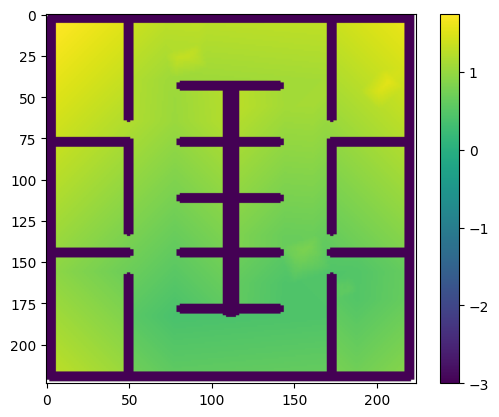

In [ ]:
robot_distance = np.load(all_datafiles[0])['robot_distance']
goal_distance = np.load(all_datafiles[0])['goal_distance']

robot_distance[robot_distance == -1] = -2

plt.imshow(robot_distance + goal_distance)
# plt.imshow(data['goal_distance'])
plt.colorbar()

In [408]:
environment_performance['env_config_1375a.xml']

{'total_episodes': 7,
 'successful_episodes': 4,
 'timeout_episodes': 3,
 'crashed_episodes': 0,
 'trivial_episodes': 0,
 'search_times': [2651.5960693359375,
  7793.516159057617,
  7460.404872894287,
  4836.91143989563,
  2102.8411388397217,
  418.27964782714844,
  1135.4966163635254],
 'nodes_expanded': [5, 10, 10, 7, 4, 1, 2],
 'terminal_checks': [7, 11, 11, 9, 6, 3, 4]}

In [416]:
hard_results = {}
hard_keys = ['4258b', '1329e', '4258a', '3354c', '3629a', '177e', '1393a', '3546c', '1793d', '1375a']
hard_success = 0
total_episodes = 0
for key in hard_keys:
    r = environment_performance[f"env_config_{key}.xml"]
    hard_results[key] = {}
    hard_results[key]['success_rate'] = r['successful_episodes'] / r['total_episodes']
    hard_success += r['successful_episodes']
    total_episodes += r['total_episodes']
    hard_results[key]['median_nodes_expanded'] = np.median(r['nodes_expanded'])
    hard_results[key]['median_terminal_checks'] = np.median(r['terminal_checks'])
    hard_results[key]['median_search_time'] = np.median(r['search_times'])


hard_success/total_episodes

0.4714285714285714

In [417]:
medium_results = {}
medium_keys = ['1362b', '1362d', '1373e', '3452a', '1376d', '3624e', '1392c', '3311a', '3624d', '1392d']
medium_success = 0
total_episodes = 0

for key in medium_keys:
    r = environment_performance[f"env_config_{key}.xml"]
    medium_results[key] = {}
    medium_results[key]['success_rate'] = r['successful_episodes'] / r['total_episodes']
    medium_success += r['successful_episodes']
    total_episodes += r['total_episodes']
    medium_results[key]['median_nodes_expanded'] = np.median(r['nodes_expanded'])
    medium_results[key]['median_terminal_checks'] = np.median(r['terminal_checks'])
    medium_results[key]['median_search_time'] = np.median(r['search_times'])

medium_success/total_episodes

0.3142857142857143

In [418]:
easy_results = {}
easy_keys = ['3327a', '3275a', '3498b', '1774d', '3937d', '3956a', '4164b', '399c', '1381c', '1376a']
easy_success = 0
total_episodes = 0

for key in easy_keys:
    r = environment_performance[f"env_config_{key}.xml"]
    easy_results[key] = {}
    easy_results[key]['success_rate'] = r['successful_episodes'] / r['total_episodes']
    easy_success += r['successful_episodes']
    total_episodes += r['total_episodes']
    easy_results[key]['median_nodes_expanded'] = np.median(r['nodes_expanded'])
    easy_results[key]['median_terminal_checks'] = np.median(r['terminal_checks'])
    easy_results[key]['median_search_time'] = np.median(r['search_times'])
    
easy_success/total_episodes

0.7142857142857143

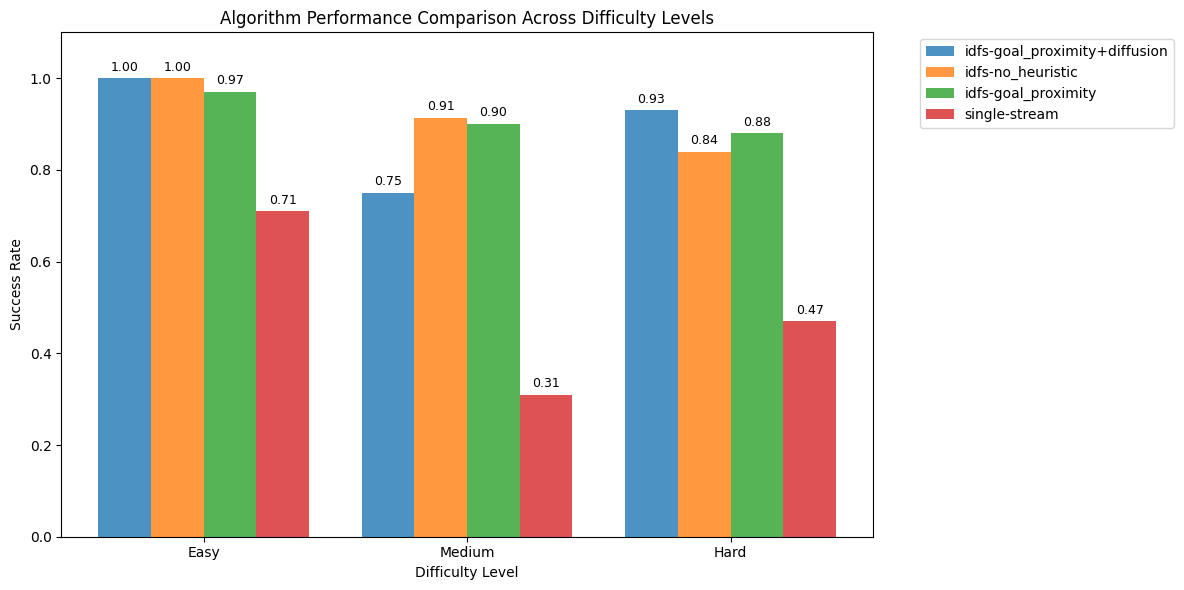

In [419]:
import matplotlib.pyplot as plt
import numpy as np

# Data for comparison
algorithms = ['idfs-goal_proximity+diffusion', 'idfs-no_heuristic', 'idfs-goal_proximity', 'single-stream']
difficulties = ['Easy', 'Medium', 'Hard']

# Reorganize data by difficulty level
easy_rates = [1.00, 1.00, 0.97, 0.71]
medium_rates = [0.75, 0.914, 0.90, 0.31]
hard_rates = [0.93, 0.84, 0.88, 0.47]

x = np.arange(len(difficulties))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5*width, [easy_rates[0], medium_rates[0], hard_rates[0]], width, label=algorithms[0], alpha=0.8)
bars2 = ax.bar(x - 0.5*width, [easy_rates[1], medium_rates[1], hard_rates[1]], width, label=algorithms[1], alpha=0.8)
bars3 = ax.bar(x + 0.5*width, [easy_rates[2], medium_rates[2], hard_rates[2]], width, label=algorithms[2], alpha=0.8)
bars4 = ax.bar(x + 1.5*width, [easy_rates[3], medium_rates[3], hard_rates[3]], width, label=algorithms[3], alpha=0.8)

ax.set_xlabel('Difficulty Level')
ax.set_ylabel('Success Rate')
ax.set_title('Algorithm Performance Comparison Across Difficulty Levels')
ax.set_xticks(x)
ax.set_xticklabels(difficulties)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim(0, 1.1)

# Add value labels on bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# hard, medium, easy
# idfs-goal_proximity+diffusion: 93%, 75%, 100%
# idfs-no_heuristic: 84%, 91.4%, 100%
# idfs-goal_proximity: 88%, 90%, 97%
# single-stream: 47%, 31%, 71%